In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from s1_frame_enumerator import (get_s1_stack, 
                                 filter_s1_stack_by_geometric_coverage_per_pass, 
                                 get_global_s1_frames, 
                                 get_overlapping_s1_frames, 
                                 enumerate_dates, 
                                 frames2gdf, 
                                 enumerate_gunw_time_series)
from shapely.geometry import Point
import geopandas as gpd
from rasterio.crs import CRS
import matplotlib.pyplot as plt
import warnings
import json
import pandas as pd

This notebook illustrates how to extract a list of SLC images for interferograms associated to fixed frame enumeration. Here "fixed frames" simply means that the frames were generated based on the ESA burst map and they *do not change in time*. They consist of 10 contiguous bursts and overlap with adjacent frames with 2 bursts. Only frames that intersect the Natural Earth land geometry are kept. More details can be found at this [repo](https://github.com/ACCESS-Cloud-Based-InSAR/s1-frame-generation) in regards to how the frames were genreated. 

The challenge with enumarating SLC imagery for interferograms using the ESA imagery (as it is distributed) is that the frames are not constant in time therefore determining the inteferogram extents becomes an accounting nightmare quickly. This "fixed frame" approach circumvents this problem by collecting all imagery that covers a given fixed frame and submits that to processing (along with its region of interest).

There are some steps to each of this.

1. Get tracks (aka relative orbit numbers or path numbers) from AOI - this is manual/user selection
2. Get fixed frames from input AOI and selected track
3. Extract all viable imagery for a stack - the stack ensures each pass is completely covered
4. Enumerate SLC imagery for interferograms

# Get track number(s) for inteferogram genration from AOI

Inteferograms require the same viewing geometry so really only one track is acceptable. We only accept 1 track number except if we are at the equator and the track number gets incremented (for ESA accounting purposes), therefore a frame has two (sequential) tracks that it tracks. Selecting an AOI over the central coast of CA.

In [3]:
aoi_geo = Point(-120, 35).buffer(1)

df_aoi = gpd.GeoDataFrame(geometry=[aoi_geo], crs=CRS.from_epsg(4326))

In [4]:
frames_all = get_overlapping_s1_frames(aoi_geo)
df_frames_all = frames2gdf(frames_all)
df_frames_all

,frame_id,track_numbers,use_land_mask,geometry
0,5285,35,True,"POLYGON Z ((-122.66251 32.67722 0.00000, -122...."
1,5286,35,True,"POLYGON Z ((-122.93144 33.84014 0.00000, -122...."
2,5287,35,True,"POLYGON Z ((-123.20029 35.00319 0.00000, -123...."
3,6452,42,True,"POLYGON Z ((-121.09286 35.45807 0.00000, -121...."
4,6453,42,True,"POLYGON Z ((-121.35006 34.29565 0.00000, -121...."
5,6454,42,True,"POLYGON Z ((-121.60530 33.13295 0.00000, -121...."
6,9849,64,True,"POLYGON Z ((-118.93254 34.35465 0.00000, -118...."
7,9850,64,True,"POLYGON Z ((-119.20601 35.53099 0.00000, -119...."
8,21248,137,True,"POLYGON Z ((-120.77265 33.40842 0.00000, -120...."
9,21249,137,True,"POLYGON Z ((-121.03949 34.56896 0.00000, -121...."


(31.49666, 38.423967)

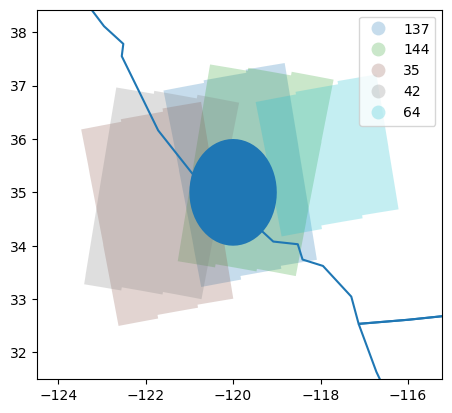

In [6]:
fig, ax = plt.subplots()
df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
df_world.boundary.plot(ax=ax)
df_frames_by_track = df_frames_all.dissolve(by='track_numbers').reset_index(drop=False)
df_frames_by_track.plot(ax=ax, 
                        column='track_numbers', 
                        alpha=.25, 
                        legend=True)
df_aoi.plot(ax=ax)
xmin, ymin, xmax, ymax = df_frames_by_track.total_bounds
ax.set_xlim(xmin - 1, xmax + 1)
ax.set_ylim(ymin - 1, ymax + 1)

(31.49666, 38.423967)

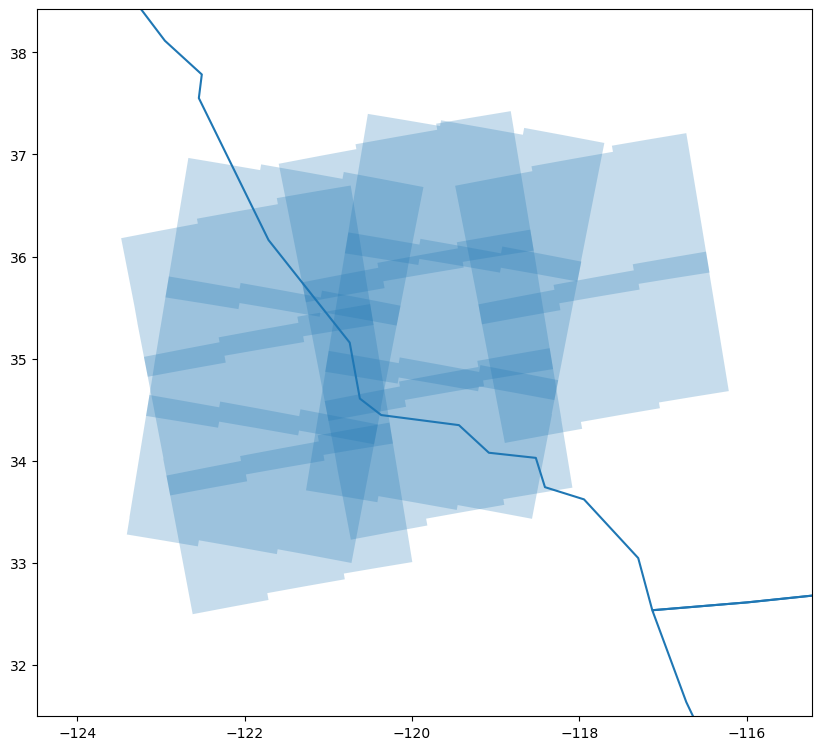

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
df_world.boundary.plot(ax=ax)
df_frames_all.plot(ax=ax, 
                        #column='track_numbers', 
                        alpha=.25, 
                        legend=True)
xmin, ymin, xmax, ymax = df_frames_by_track.total_bounds
ax.set_xlim(xmin - 1, xmax + 1)
ax.set_ylim(ymin - 1, ymax + 1)

# Get Frames from AOI and selected track

We *manually* select a track - could skip right to this point if we knew the AOI and track had overlap.

In [8]:
track_numbers = [144]
frames = get_overlapping_s1_frames(aoi_geo, track_numbers=track_numbers)
frames

[S1Frame(frame_geometry=<POLYGON Z ((-118.512 35.829 0, -118.938 35.89 0, -118.949 35.842 0, -119.45...>, frame_id=22438, track_numbers=[144], use_land_mask=True, coverage_geometry=<POLYGON Z ((-118.938 35.89 0, -118.949 35.842 0, -119.458 35.915 0, -119.91...>),
 S1Frame(frame_geometry=<POLYGON Z ((-119.199 34.728 0, -119.21 34.681 0, -119.712 34.753 0, -120.15...>, frame_id=22439, track_numbers=[144], use_land_mask=True, coverage_geometry=<POLYGON Z ((-119.21 34.681 0, -119.712 34.753 0, -120.159 34.815 0, -120.17...>),
 S1Frame(frame_geometry=<POLYGON Z ((-119.454 33.566 0, -119.465 33.518 0, -119.96 33.591 0, -120.40...>, frame_id=22440, track_numbers=[144], use_land_mask=True, coverage_geometry=<POLYGON Z ((-120.571 35.016 0, -120.158 34.956 0, -120.146 35.012 0, -119.6...>)]

<AxesSubplot: >

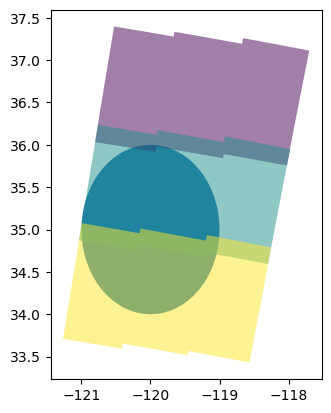

In [9]:
fig, ax = plt.subplots()

df_aoi.plot(ax=ax)
df_overlapping_frames = frames2gdf(frames)
df_overlapping_frames.plot(column='frame_id', alpha=.5, ax=ax)

# Get Stack from Frame

Here a stack is a list of images with metadata and extents. We note the stack here is not arbitrarily constructed and at some point might be nice to create a simple class to encapsulate it. However, here a stack is one that can be organized to do interferometry over the frames.

1. Per frame coverage $\geq 99$% as it pertains to the frame's coverage geometry
2. Contiguous coverage through frames (determined as Polygon object)

Requires:

1. Frames to be contiguous (otherwise 2. does not make sense)
2. Requires single track or two sequential tracks (we only check if the track numbers are sequential)

In [10]:
df_stack = get_s1_stack(frames)
df_stack.head()

,slc_id,start_time,stop_time,url,track_number,polarization,orbit,beam_mode,size_gb,stack_repeat_pass_id,repeat_pass_date,geometry
0,S1A_IW_SLC__1SSV_20150519T135922_20150519T1359...,2015-05-19 13:59:22+00:00,2015-05-19 13:59:49+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,144,VV,5991,IW,2.474112,9,2015-05-19,"POLYGON ((-118.03455 35.87319, -117.64374 37.4..."
1,S1A_IW_SLC__1SSV_20150519T135947_20150519T1400...,2015-05-19 13:59:47+00:00,2015-05-19 14:00:14+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,144,VV,5991,IW,2.482766,9,2015-05-19,"POLYGON ((-118.37766 34.31689, -117.98006 35.9..."
2,S1A_IW_SLC__1SSV_20150519T140012_20150519T1400...,2015-05-19 14:00:12+00:00,2015-05-19 14:00:39+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,144,VV,5991,IW,2.279615,9,2015-05-19,"POLYGON ((-118.71146 32.81956, -118.33259 34.4..."
3,S1A_IW_SLC__1SSV_20150612T135923_20150612T1359...,2015-06-12 13:59:23+00:00,2015-06-12 13:59:50+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,144,VV,6341,IW,2.504498,11,2015-06-12,"POLYGON ((-118.02811 35.87192, -117.63700 37.4..."
4,S1A_IW_SLC__1SSV_20150612T135948_20150612T1400...,2015-06-12 13:59:48+00:00,2015-06-12 14:00:15+00:00,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,144,VV,6341,IW,2.429534,11,2015-06-12,"POLYGON ((-118.35521 34.37390, -117.97107 35.9..."


In [11]:
df_stack.shape

(1137, 12)

# Generate Pairs

Now we generate the frames - most important elements of returned data is:

1. SLC Ids of reference and secondary
2. Extent of related frames

In [12]:
min_temporal_baseline = 30
neighbors = 3

data = enumerate_gunw_time_series(frames, 
                                  df_stack, 
                                  min_temporal_baseline, 
                                  n_secondary_scenes_per_ref=neighbors,
                                  )

Date Pairs: 100%|████████████████████| 867/867 [01:48<00:00,  8.00it/s]


In [13]:
data[0]

{'reference': ['S1A_IW_SLC__1SDV_20230125T135954_20230125T140021_046941_05A132_D35C',
  'S1A_IW_SLC__1SDV_20230125T140019_20230125T140046_046941_05A132_82DF'],
 'secondary': ['S1A_IW_SLC__1SDV_20221220T135956_20221220T140023_046416_058F77_B248',
  'S1A_IW_SLC__1SDV_20221220T140020_20221220T140047_046416_058F77_5213'],
 'reference_date': datetime.date(2023, 1, 25),
 'secondary_date': datetime.date(2022, 12, 20),
 'frame_id': 22438,
 'geometry': <POLYGON Z ((-118.512 35.829 0, -118.938 35.89 0, -118.949 35.842 0, -119.45...>}

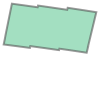

In [14]:
data[0]['geometry']

## Serialize

In [15]:
def update_item(item: dict):
    new_item = item.copy()
    new_item['bbox'] = list(item['geometry'].bounds)
    new_item.pop('geometry')
    return new_item

data_ifg = list(map(update_item, data))
data_ifg[0]

{'reference': ['S1A_IW_SLC__1SDV_20230125T135954_20230125T140021_046941_05A132_D35C',
  'S1A_IW_SLC__1SDV_20230125T140019_20230125T140046_046941_05A132_82DF'],
 'secondary': ['S1A_IW_SLC__1SDV_20221220T135956_20221220T140023_046416_058F77_B248',
  'S1A_IW_SLC__1SDV_20221220T140020_20221220T140047_046416_058F77_5213'],
 'reference_date': datetime.date(2023, 1, 25),
 'secondary_date': datetime.date(2022, 12, 20),
 'frame_id': 22438,
 'bbox': [-120.802121, 35.755765, -117.700682, 37.397148]}

In [16]:
AOI_TOKEN = 'California'
TRACK_TOKENS = ','.join(list(map(str, track_numbers)))

# json.dump(data_ifg, 
#           open(f'ifg_pair_{AOI_TOKEN}_{TRACK_TOKENS}.json', 'w'),
#           indent=2
#          )

# Visualization (optional)


We are going to visualize the time series and individual frame coverage below. 

## Dates in Time-Series

In [17]:
from s1_frame_enumerator import enumerate_dates
import networkx as nx

In [18]:
unique_dates = df_stack.repeat_pass_date.unique()
date_pairs = enumerate_dates(unique_dates, 30)
date_pairs[:3]

[(datetime.date(2023, 1, 25), datetime.date(2022, 12, 20)),
 (datetime.date(2023, 1, 25), datetime.date(2022, 12, 8)),
 (datetime.date(2023, 1, 25), datetime.date(2022, 11, 26))]

In [19]:
# Get unique dates
unique_dates = sorted(list(set(unique_dates)))

# initiate and plot date notes
date2node = {date: k for (k, date) in enumerate(unique_dates)}
node2date = {k: date for (date, k) in date2node.items()}

G = nx.DiGraph()

edges = [(date2node[ref_date], date2node[sec_date]) 
         for (ref_date, sec_date) in date_pairs]
G.add_edges_from(edges)

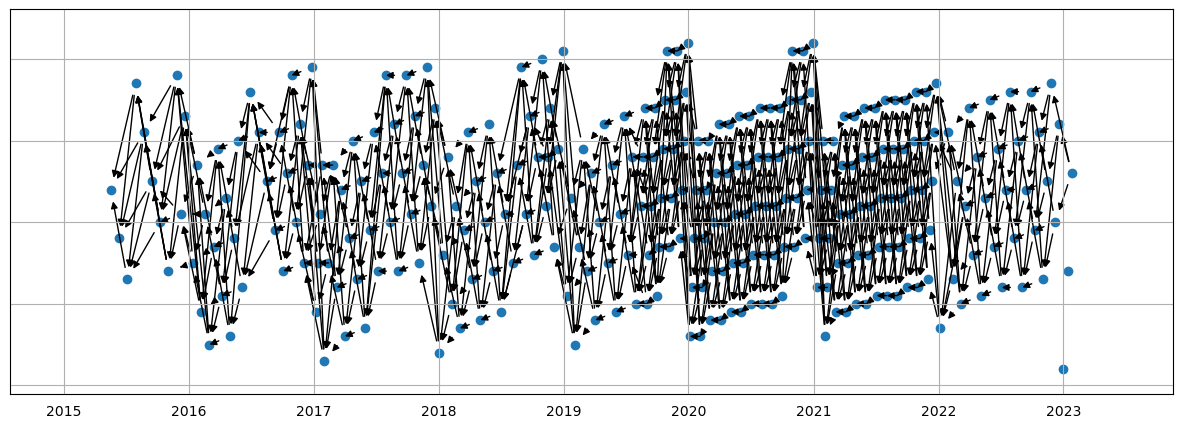

In [20]:
fig, ax = plt.subplots(figsize=(15, 5))

increment = [date.month + date.day for date in unique_dates]

# source: https://stackoverflow.com/a/27852570
scat = ax.scatter(unique_dates, increment)
position = scat.get_offsets().data

pos = {date2node[date]: position[k] for (k, date) in enumerate(unique_dates)}
nx.draw_networkx_edges(G, pos=pos, ax=ax)
ax.grid('on')
ax.tick_params(axis='x',
               which='major',
               labelbottom=True,
               labelleft=True)
ymin, ymax = ax.get_ylim()

# Image Coverage

In [21]:
K = 0#100
data[K:K+2]

[{'reference': ['S1A_IW_SLC__1SDV_20230125T135954_20230125T140021_046941_05A132_D35C',
   'S1A_IW_SLC__1SDV_20230125T140019_20230125T140046_046941_05A132_82DF'],
  'secondary': ['S1A_IW_SLC__1SDV_20221220T135956_20221220T140023_046416_058F77_B248',
   'S1A_IW_SLC__1SDV_20221220T140020_20221220T140047_046416_058F77_5213'],
  'reference_date': datetime.date(2023, 1, 25),
  'secondary_date': datetime.date(2022, 12, 20),
  'frame_id': 22438,
  'geometry': <POLYGON Z ((-118.512 35.829 0, -118.938 35.89 0, -118.949 35.842 0, -119.45...>},
 {'reference': ['S1A_IW_SLC__1SDV_20230125T140019_20230125T140046_046941_05A132_82DF',
   'S1A_IW_SLC__1SDV_20230125T140044_20230125T140111_046941_05A132_59E7'],
  'secondary': ['S1A_IW_SLC__1SDV_20221220T140020_20221220T140047_046416_058F77_5213',
   'S1A_IW_SLC__1SDV_20221220T140045_20221220T140112_046416_058F77_7692'],
  'reference_date': datetime.date(2023, 1, 25),
  'secondary_date': datetime.date(2022, 12, 20),
  'frame_id': 22439,
  'geometry': <POLY

In [22]:
df_frame = gpd.GeoDataFrame(data[K:K+1], 
                            geometry=[data[K]['geometry']],
                            crs=CRS.from_epsg(4326))

df_ref = df_stack[df_stack.slc_id.isin(data[K]['reference'])].reset_index(drop=True)
df_sec = df_stack[df_stack.slc_id.isin(data[K]['secondary'])].reset_index(drop=True)

Text(0.5, 1.0, 'Secondary SLCs (blue) \n and frame (yellow)')

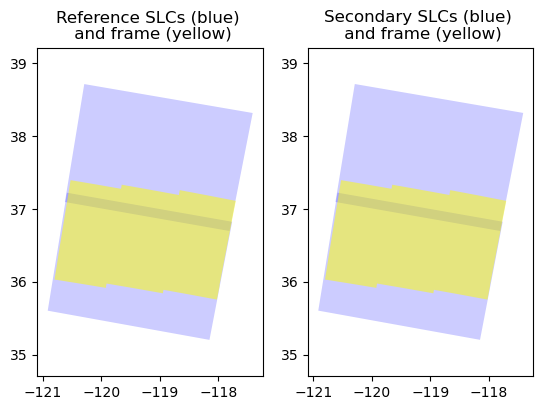

In [23]:
fig, ax = plt.subplots(1, 2)

df_ref.plot(ax=ax[0], alpha=.2, color='blue')
df_frame.plot(ax=ax[0], alpha=.5, color='yellow')

df_sec.iloc[:4].plot(ax=ax[1], alpha=.2, color='blue')
df_frame.plot(ax=ax[1], alpha=.5, color='yellow')

xmin, ymin, xmax, ymax = pd.concat([df_ref, df_sec], axis=0).total_bounds

ax[0].set_ylim(ymin - .5, ymax + .5)
ax[0].set_title('Reference SLCs (blue) \n and frame (yellow)')
ax[1].set_ylim(ymin - .5, ymax + .5)
ax[1].set_title('Secondary SLCs (blue) \n and frame (yellow)')


In [24]:
N = 1000
df_frames = gpd.GeoDataFrame(data[K:K+N], 
                             geometry=[data[k]['geometry'] for k in range(K, K+N)],
                             crs=CRS.from_epsg(4326))

df_ref = df_stack[df_stack.slc_id.isin(data[K]['reference'])].reset_index(drop=True)
df_sec = df_stack[df_stack.slc_id.isin(data[K]['secondary'])].reset_index(drop=True)
# Get distinct frames
df_frames.drop_duplicates(subset='frame_id', keep='first', inplace=True)
df_frames

,reference,secondary,reference_date,secondary_date,frame_id,geometry
0,[S1A_IW_SLC__1SDV_20230125T135954_20230125T140...,[S1A_IW_SLC__1SDV_20221220T135956_20221220T140...,2023-01-25,2022-12-20,22438,"POLYGON Z ((-118.51228 35.82872 0.00000, -118...."
1,[S1A_IW_SLC__1SDV_20230125T140019_20230125T140...,[S1A_IW_SLC__1SDV_20221220T140020_20221220T140...,2023-01-25,2022-12-20,22439,"POLYGON Z ((-119.19912 34.72842 0.00000, -119...."
2,[S1A_IW_SLC__1SDV_20230125T140044_20230125T140...,[S1A_IW_SLC__1SDV_20221220T140045_20221220T140...,2023-01-25,2022-12-20,22440,"POLYGON Z ((-119.45444 33.56574 0.00000, -119...."


In [25]:
distinct_frames_data = df_frames.to_dict('records')
distinct_frames_data

[{'reference': ['S1A_IW_SLC__1SDV_20230125T135954_20230125T140021_046941_05A132_D35C',
   'S1A_IW_SLC__1SDV_20230125T140019_20230125T140046_046941_05A132_82DF'],
  'secondary': ['S1A_IW_SLC__1SDV_20221220T135956_20221220T140023_046416_058F77_B248',
   'S1A_IW_SLC__1SDV_20221220T140020_20221220T140047_046416_058F77_5213'],
  'reference_date': datetime.date(2023, 1, 25),
  'secondary_date': datetime.date(2022, 12, 20),
  'frame_id': 22438,
  'geometry': <POLYGON Z ((-118.512 35.829 0, -118.938 35.89 0, -118.949 35.842 0, -119.45...>},
 {'reference': ['S1A_IW_SLC__1SDV_20230125T140019_20230125T140046_046941_05A132_82DF',
   'S1A_IW_SLC__1SDV_20230125T140044_20230125T140111_046941_05A132_59E7'],
  'secondary': ['S1A_IW_SLC__1SDV_20221220T140020_20221220T140047_046416_058F77_5213',
   'S1A_IW_SLC__1SDV_20221220T140045_20221220T140112_046416_058F77_7692'],
  'reference_date': datetime.date(2023, 1, 25),
  'secondary_date': datetime.date(2022, 12, 20),
  'frame_id': 22439,
  'geometry': <POLY

In [26]:
df_frames.bounds

,minx,miny,maxx,maxy
0,-120.802121,35.755765,-117.700682,37.397148
1,-121.036540,34.593842,-117.976649,36.236470
2,-121.266680,33.430896,-118.252317,35.075853


In [27]:
df_frames.to_file('sample_frame_submissions.geojson', driver='GeoJSON')

ValueError: Invalid field type <class 'list'>